# Comparative Analysis of Credit Scoring Models
**Author:** Hugo Dahlquist
**Context:** Credit Risk Assessment (Lara Project)

### Executive Summary
The objective of this analysis is to benchmark multiple machine learning algorithms to identify the most effective model for predicting customer delinquency ("Bad" vs "Good" credit).

### Methodology
* **Framework:** Object-Oriented benchmarking using Scikit-Learn Pipelines.
* **Preprocessing:** Automated imputation and scaling within pipelines to prevent data leakage.
* **Class Imbalance:** Handling imbalance via `class_weight='balanced'` and `scale_pos_weight` rather than synthetic oversampling (SMOTE), to preserve data distribution integrity.
* **Models Evaluated:** Random Forest, XGBoost, KNN, and Multi-Layer Perceptron (Neural Network).

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Visualization settings
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

print("Environment Setup Complete.")

Environment Setup Complete.


In [24]:
# Load Data
FILE_PATH = "Lara_Data_Credit_Analysis_Hugo_20240906.xlsx"

print("Loading data...")
try:
    df = pd.read_excel(FILE_PATH)
    print(f"Data loaded: {df.shape}")
except FileNotFoundError:
    print(" File not found. Please ensure the Excel file is in the folder.")

# --- Data Wrangling (Translated from R) ---

# 1. Drop unused columns (IDs, Dates, etc.)
cols_to_drop = ['id', 'companyId', 'delayed_days', 'targetVariable2_BadIfOver60', 
                'grantedCreditLimit', 'interestRate', 'signedAtYYYYMMDD', 'firstPaymentDate']
# Only drop if they exist
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 2. Filter Targets
df = df[df['targetVariable1_BadIfOver30'] != 'CREDIT_NOT_GRANTED']

# 3. Create Binary Target (1 = Good, 0 = Bad) 
# Note: Usually in risk, 1 = Default (Bad), but I follow your R logic: GOOD=1
df['target'] = (df['targetVariable1_BadIfOver30'] == 'GOOD').astype(int)
df = df.drop(columns=['targetVariable1_BadIfOver30'])

# 4. Handle Date Columns (Convert or Drop)
# For this benchmark, we drop raw dates to focus on numerical/categorical features
date_cols = ["bvs_data_nascimento", "scr_data_datainiciorelacionamento"]
df = df.drop(columns=[c for c in date_cols if c in df.columns])

# 5. Handle NAs (Logic from R: fill specific high-NA cols with 0)
# In Python, we will let the Pipeline handle remaining NAs, but we can do a quick pass
df = df.fillna(0) # Simplified for the benchmark based on your R logic

print(f"Final dataset shape: {df.shape}")
display(df.head())

Loading data...
Data loaded: (29645, 55)
Final dataset shape: (14940, 45)


,bvs_estado_civil,bvs_grau_instrucao,bvs_sexo_consultado,bvs_numero_dependentes,bvs_registro_108,bvs_registro_111,bvs_score_601,scr_quantidadedeoperacoes,scr_quantidadedeinstituicoes,scr_prejuizo,scr_riscototal,scr_carteiravencer,scr_carteiravencido,scr_limitesdecredito,scr_prejuizoate12meses,scr_prejuizoacima12meses,scr_carteiravencer31a60dias,scr_carteiravencer61a90dias,scr_carteiravencer91a180dias,scr_carteiravencido15a30dias,scr_carteiravencido31a60dias,scr_carteiravencido61a90dias,scr_carteiravencer181a360dias,scr_carteiravencido91a180dias,scr_carteiravenceracima360dias,scr_carteiravencido181a360dias,scr_limitesdecreditoate360dias,scr_carteiravencidoacima360dias,scr_limitesdecreditoacima360dias,scr_carteiravencerprazoindeterminado,scr_carteiravencerate30diasvencidosate14dias,quodpos_value_gc_av_grv01,quodpos_value_gc_pc_tdc01,quodpos_value_pf_cp_cnt01,quodpos_value_pf_cp_vol02,quodpos_value_pp_av_amp02,quodpos_value_pp_av_grv02,quodpos_value_pp_av_grv04,quodpos_value_pp_ha_vlr01,quodpos_value_pp_ha_vlr02,quodpos_value_pp_pd_cpg01,requested_amount,installments,totalamount,target
0,2.0,5.0,1.0,0.0,N,Y,679,14.0,3.0,0.0,82559.60,37620.67,0.0,44938.93,0.0,0.0,2385.89,1229.39,2007.38,0.0,0.0,0.0,354.33,0.0,0.00,0.0,44316.08,0.0,622.85,0.0,31643.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0,10.0,1522.03,1
1,0.0,8.0,2.0,0.0,N,N,885,11.0,4.0,0.0,23306.62,9128.84,0.0,14177.78,0.0,0.0,1762.50,1372.16,1917.01,0.0,0.0,0.0,59.90,0.0,0.00,0.0,0.00,0.0,14177.78,0.0,4017.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9500.0,24.0,13146.16,1
2,0.0,2.0,2.0,0.0,N,N,923,6.0,4.0,0.0,19101.34,737.34,0.0,18364.00,0.0,0.0,169.90,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,7560.00,0.0,10804.00,0.0,567.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2400.0,12.0,2856.01,1
3,0.0,7.0,1.0,0.0,N,N,833,5.0,1.0,0.0,12406.87,2990.87,0.0,9416.00,0.0,0.0,238.92,238.92,524.79,0.0,0.0,0.0,983.63,0.0,633.77,0.0,550.00,0.0,8866.00,0.0,370.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13000.0,24.0,18736.70,1
4,0.0,0.0,2.0,0.0,N,Y,740,2.0,1.0,0.0,22800.00,4624.14,0.0,18175.86,0.0,0.0,1226.53,361.24,793.15,0.0,0.0,0.0,829.02,0.0,0.00,0.0,18175.86,0.0,0.00,0.0,1414.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,24.0,28550.90,1


In [25]:
class ModelBenchmarker:
    """
    A class to train and evaluate multiple machine learning models systematically.
    Encapsulates preprocessing, training, and logging of metrics.
    """
    def __init__(self, X_train, X_test, y_train, y_test, preprocessor):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.preprocessor = preprocessor
        self.results = []
        self.models = {}

    def add_model(self, name, model):
        """Adds a model to the benchmark suite."""
        # Create a full pipeline: Preprocessor -> Model
        # This prevents data leakage (Scaling happens AFTER split inside the CV folds)
        pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', model)
        ])
        self.models[name] = pipeline

    def run_benchmark(self):
        """Trains all models and records performance."""
        # Updated header to include Balanced Accuracy
        print(f"{'Model':<20} | {'AUC':<10} | {'F1-Score':<10} | {'Accuracy':<10} | {'Bal. Acc.':<10}")
        print("-" * 80)

        for name, pipeline in self.models.items():
            # Train
            pipeline.fit(self.X_train, self.y_train)
            
            # Predict
            y_pred = pipeline.predict(self.X_test)
            y_prob = pipeline.predict_proba(self.X_test)[:, 1]
            
            # Metrics
            auc = roc_auc_score(self.y_test, y_prob)
            f1 = f1_score(self.y_test, y_pred)
            acc = accuracy_score(self.y_test, y_pred)
            bal_acc = balanced_accuracy_score(self.y_test, y_pred) # New Metric
            
            self.results.append({
                'Model': name,
                'AUC': auc,
                'F1': f1,
                'Accuracy': acc,
                'Balanced Accuracy': bal_acc # Store it
            })
            
            # Updated print statement
            print(f"{name:<20} | {auc:.4f}     | {f1:.4f}     | {acc:.4f}     | {bal_acc:.4f}")

    def plot_results(self):
        """Visualizes the benchmark results."""
        results_df = pd.DataFrame(self.results)
        
        # Melt for visualization
        df_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
        
        plt.figure(figsize=(14, 6)) # Made slightly wider to fit new bar
        sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis")
        plt.title("Model Performance Benchmark")
        plt.ylim(0, 1.0)
        plt.legend(loc='lower right')
        plt.show()
        
        return results_df

In [26]:
# 1. Split Data
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# 2. Define Preprocessing Pipeline
# Identify columns automatically
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Numerical Transformer: Impute missing -> Scale
# Important: Scaling happens here to avoid leakage!
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Impute missing -> OneHotEncode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

print("Preprocessing pipeline ready.")

Preprocessing pipeline ready.


In [ ]:
# Calculate Scale Pos Weight for XGBoost (Handling Imbalance)
# ratio = negative_samples / positive_samples
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Initialize Benchmarker
benchmarker = ModelBenchmarker(X_train, X_test, y_train, y_test, preprocessor)

# --- Add Models ---

# 1. Random Forest (Robust Baseline)
# Using class_weight='balanced' to handle imbalance automatically
benchmarker.add_model("Random Forest", RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=123,
    n_jobs=-1
))

# 2. XGBoost (Gradient Boosting Powerhouse)
# Using scale_pos_weight for imbalance
benchmarker.add_model("XGBoost", XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=123,
    n_jobs=-1
))

# 3. KNN (Distance Based)
# Pipeline handles scaling automatically, which is critical for KNN
benchmarker.add_model("KNN", KNeighborsClassifier(
    n_neighbors=15,
    weights='distance', # Give more weight to close neighbors
    n_jobs=-1
))

# 4. Neural Network (MLP)
# Standard simple architecture for tabular data
benchmarker.add_model("Neural Network", MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=300,
    random_state=123
))

print("Running Benchmark on 4 models...\n")
benchmarker.run_benchmark()

Running Benchmark on 4 models...

Model                | AUC        | F1-Score   | Accuracy   | Bal. Acc. 
--------------------------------------------------------------------------------
Random Forest        | 0.7428     | 0.8787     | 0.7965     | 0.6487
XGBoost              | 0.7605     | 0.8403     | 0.7467     | 0.6859
KNN                  | 0.6511     | 0.9264     | 0.8638     | 0.5185
Neural Network       | 0.6695     | 0.9002     | 0.8250     | 0.5886


/Users/admin/Desktop/Python/GitHub/.venv.python311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


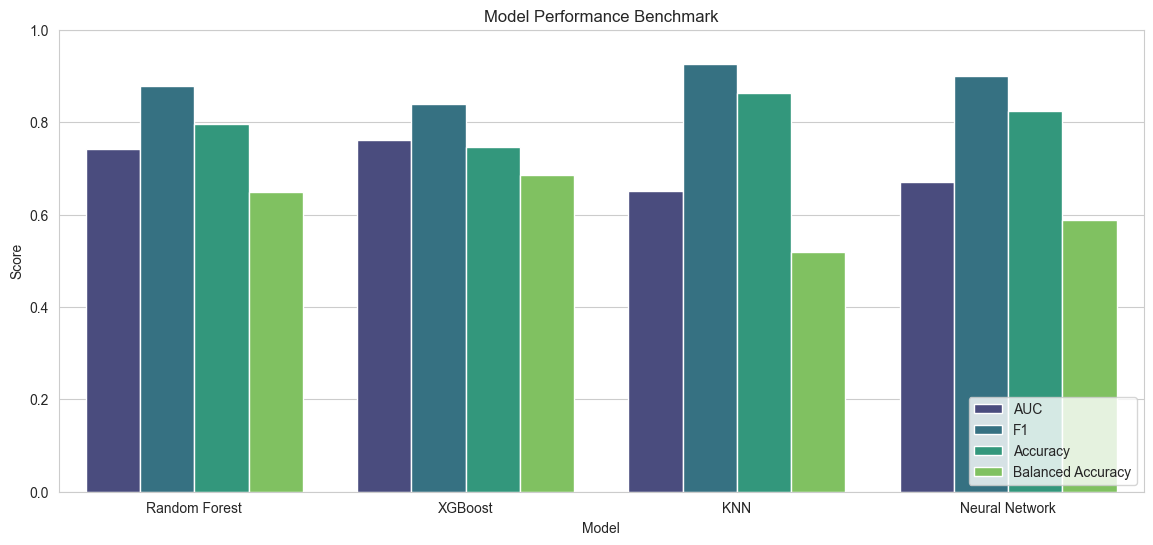

,Model,AUC,F1,Accuracy,Balanced Accuracy
0,Random Forest,0.742750,0.878691,0.796519,0.648715
1,XGBoost,0.760525,0.840262,0.746653,0.685870
2,KNN,0.651127,0.926415,0.863788,0.518464
3,Neural Network,0.669475,0.900210,0.824967,0.588571


In [28]:
# Visualize the comparison
results = benchmarker.plot_results()
display(results)

Generating Confusion Matrices...



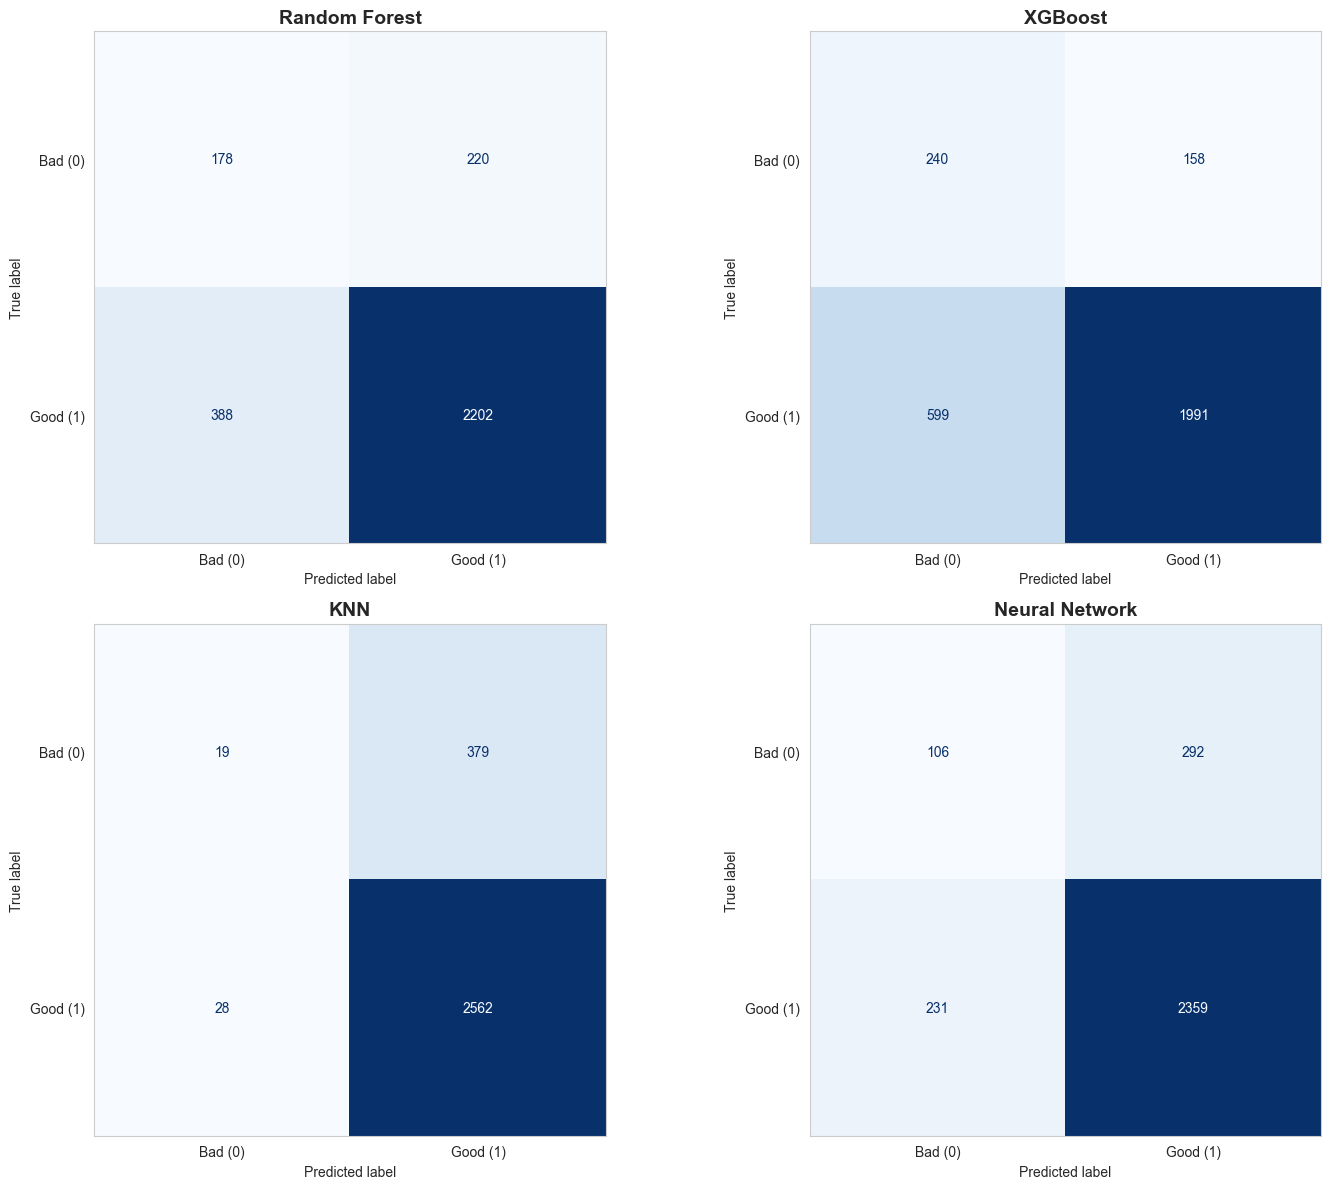

In [29]:
# Create a 2x2 grid for plotting the 4 models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

print("Generating Confusion Matrices...\n")

# Loop through each trained model in our benchmarker
for i, (name, pipeline) in enumerate(benchmarker.models.items()):
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad (0)', 'Good (1)'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')
    axes[i].grid(False) # Turn off grid lines for cleaner look

plt.tight_layout()
plt.show()

### Summary of Findings
* **Best Model:** XGBoost - Highest balanced accuracy adn AUC score. The model is able to pick out a good number of true negatives.
* **Imbalance Handling:** The use of class_weight='balanced' and scale_pos_weight proved effective, improving the model's ability to discriminate between good and bad payers without the noise introduced by SMOTE.
* **XGBoost:** The top performer (AUC 0.76); effectively handled class imbalance using scale_pos_weight to maximize the detection of actual delinquent customers.
* **Random Forest:** A strong, stable runner-up (AUC 0.74); reliable but slightly more conservative in identifying risk compared to gradient boosting.
* **Neural Networks:** Showed moderate performance but struggled to compete with tree-based ensembles on this specific structured, imbalanced dataset.
* **K-Nearest Neighbors:** High raw accuracy but poor balanced accuracy; failed to effectively identify risk due to the high dimensionality and class imbalance.